In [2]:
using ITensorMPS
using ITensors
using Plots
using DelimitedFiles
using ITensorEntropyTools


# Find Ground State

In [53]:
N_s = 16
sites = siteinds("S=1/2", N_s)

J = 0.2
h = 1
g = 0.3

os = OpSum()
for j=1:N_s
    if j == N_s
        os -= J, "X", j, "X", 1
        os -= g, "Z", j, "Z", 1
    else
        os -= J, "X", j, "X", j+1
        os -= g, "Z", j, "Z", j+1
    end
    os -= h, "Z", j
end
H = MPO(os, sites)

psi0 = randomMPS(sites; linkdims=2^7)

nsweeps = 15
maxdim = [10,20,100,100,200]
cutoff = [1E-10]
noise = [1E-6]
weight = 50

energy0,psi0 = dmrg(H,psi0;nsweeps,maxdim,cutoff)

After sweep 1 energy=-20.92316886904334  maxlinkdim=10 maxerr=3.29E-04 time=0.039
After sweep 2 energy=-20.923170113165014  maxlinkdim=6 maxerr=8.80E-11 time=0.011
After sweep 3 energy=-20.923170113165114  maxlinkdim=6 maxerr=8.29E-11 time=0.024
After sweep 4 energy=-20.92317011316512  maxlinkdim=6 maxerr=8.29E-11 time=0.019
After sweep 5 energy=-20.92317011316507  maxlinkdim=6 maxerr=8.29E-11 time=0.014
After sweep 6 energy=-20.92317011316507  maxlinkdim=6 maxerr=8.29E-11 time=0.016
After sweep 7 energy=-20.923170113165085  maxlinkdim=6 maxerr=8.29E-11 time=0.011
After sweep 8 energy=-20.92317011316512  maxlinkdim=6 maxerr=8.29E-11 time=0.014
After sweep 9 energy=-20.923170113165092  maxlinkdim=6 maxerr=8.29E-11 time=0.009
After sweep 10 energy=-20.923170113165096  maxlinkdim=6 maxerr=8.29E-11 time=0.013
After sweep 11 energy=-20.923170113165085  maxlinkdim=6 maxerr=8.29E-11 time=0.010
After sweep 12 energy=-20.923170113165067  maxlinkdim=6 maxerr=8.29E-11 time=0.012
After sweep 13 en

(-20.9231701131651, MPS(16))

# Two-Particle Scattering

In [54]:
function rz(theta::Float64, i::Int, psi::MPS, cutoff::Float64)
    s = siteinds(psi)
    z_i = op("Z", s[i])
    Op = exp(-1im/2 * theta * z_i)
    psi = apply(Op, psi; cutoff)
    return psi
end

function giv_op(theta::Float64, i::Int, j::Int, psi::MPS, cutoff::Float64)
    s = siteinds(psi)
    x_i = op("X", s[i])
    y_i = op("Y", s[i])
    x_j = op("X", s[j])
    y_j = op("Y", s[j])
    Op = x_i * y_j - x_j * y_i
    Op = exp(1im * theta / 2 * Op)
    psi = apply(Op, psi; cutoff)
    return psi
end

giv_op (generic function with 1 method)

In [55]:
betas_r = [-0.0, 1.3744467859455345, 2.748893571891069, -2.159844949342983, -0.7853981633974485, 0.5890486225480858, 1.963495408493621, -2.945243112740432, -1.570796326794897, -0.19634954084936188, 1.1780972450961715, 2.5525440310417067, -2.356194490192345, -0.9817477042468112, 0.39269908169872203, 1.767145867644259]
thetas_r = [-1.552482735564815, -1.5706584371129124, -1.5707958999454112, -1.5707963262516735, -1.5707958999454112, -1.5706584371142231, -1.5524858062165494, -0.78556584796951, -0.06293258533404583, -0.10815922731362669, -0.2591826353119011, -0.5856931785221103, -1.080075595502084, -1.4472062219682158, -1.5574379758600176]
betas_l = [-0.0, -1.3744467859455345, -2.748893571891069, 2.159844949342983, 0.7853981633974485, -0.5890486225480858, -1.963495408493621, 2.945243112740432, 1.570796326794897, 0.1963495408493619, -1.1780972450961715, -2.5525440310417067, 2.356194490192345, 0.9817477042468111, -0.39269908169872203, -1.767145867644259]
thetas_l = [-0.04452198563441429, -0.10805301996727842, -0.2591797798360549, -0.5856928297606335, -1.0800754993432038, -1.4472061999518906, -1.5574379734927726, -1.570201210872939, -1.570785426867217, -1.5707962447207928, -1.5707963265408291, -1.5707963267945733, -1.5707963265408291, -1.5707962447207928, -1.5707854268672177]


15-element Vector{Float64}:
 -0.04452198563441429
 -0.10805301996727842
 -0.2591797798360549
 -0.5856928297606335
 -1.0800754993432038
 -1.4472061999518906
 -1.5574379734927726
 -1.570201210872939
 -1.570785426867217
 -1.5707962447207928
 -1.5707963265408291
 -1.5707963267945733
 -1.5707963265408291
 -1.5707962447207928
 -1.5707854268672177

In [56]:
cutoff = 1E-8
maxdim = 20

# Make an array of 'site' indices
s = siteinds(psi0)

# State Preparation
n_kr = 7
n_kl = -n_kr
sigma = 3/2

init_state = deepcopy(psi0)

for x in 1:N_s
    init_state = rz(betas_r[x], x, init_state, cutoff)
end
for x in 1:N_s-1
    y = N_s - x
    init_state = giv_op(thetas_r[x], y, y+1, init_state, cutoff)
end
sm = op("X", s[1]) - 1im * op("Y", s[1])
init_state = apply(sm, init_state; cutoff)
for x in 1:N_s-1
    y = N_s - x
    init_state = giv_op(-thetas_r[y], x, x+1, init_state, cutoff)
end
for x in 1:N_s
    init_state = rz(-betas_r[x], x, init_state, cutoff)
end

for x in 1:N_s
    init_state = rz(betas_l[x], x, init_state, cutoff)
end
for x in 1:N_s-1
    y = N_s - x
    init_state = giv_op(thetas_l[x], y, y+1, init_state, cutoff)
end
sm = op("X", s[1]) - 1im * op("Y", s[1])
init_state = apply(sm, init_state; cutoff)
for x in 1:N_s-1
    y = N_s - x
    init_state = giv_op(-thetas_l[y], x, x+1, init_state, cutoff)
end
for x in 1:N_s
    init_state = rz(-betas_l[x], x, init_state, cutoff)
end

[0.003106891420193547, 0.017576815360037856, 0.21961465506655647, 0.5321814843636697, 0.21961464839989114, 0.017576993439133104, 0.0031070781026097394, 0.0029637026608947403, 0.003106685538010634, 0.017575597609542137, 0.21961340488343778, 0.5321817574724913, 0.21961343566398994, 0.017575611124337587, 0.003106538152688909, 0.002963552035257666]


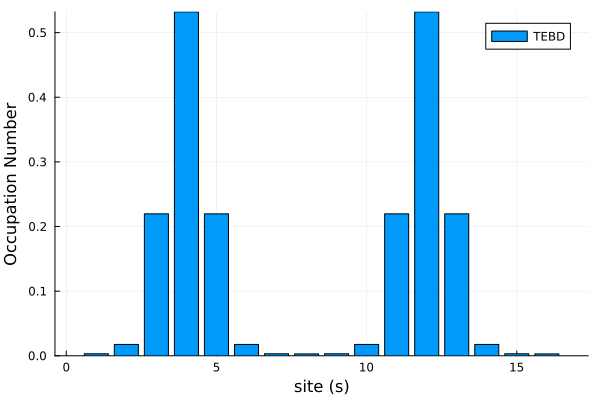

In [57]:
magz = expect(init_state, "Z")
occs = [(1 - magz[n])/2 for n=1:N_s]
println(occs)

sites = [n for n=1:N_s]
plot(bar(sites, occs; label="TEBD"), xlabel="site (s)", ylabel="Occupation Number")

In [58]:
# Make Time-Evolution Gates
tau = 0.05
N_t = 300

gates = ITensor[]
for j in 1:N_s
    s1 = s[j]
    if j == N_s
        s2 = s[1]
    else
        s2 = s[j+1]
    end
    
    x1 = op("X", s1)
    x2 = op("X", s2)

    hxx = -J * x1 * x2

    Gj = exp(-1im * tau * hxx)

    push!(gates, Gj)

    hz = -h * op("Z", s1)
    Gj = exp(-1im * tau * hz)
    push!(gates, Gj)

    z1 = op("Z", s1)
    z2 = op("Z", s2)

    hzz = -g * z1 * z2

    Gj = exp(-1im * tau * hzz)
    push!(gates, Gj)
end

# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
append!(gates, reverse(gates))

96-element Vector{ITensor}:
 ITensor ord=4
Dim 1: (dim=2|id=163|"S=1/2,Site,n=1")
Dim 2: (dim=2|id=624|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=163|"S=1/2,Site,n=1")'
Dim 4: (dim=2|id=624|"S=1/2,Site,n=2")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 0.9999500004166653 + 0.0im  0.0 + 0.0im
                0.0 + 0.0im  0.0 + 0.009999833334166664im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.009999833334166664im
 0.9999500004166653 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im                   0.9999500004166652 + 0.0im
 0.0 + 0.009999833334166664im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.009999833334166664im                 0.0 + 0.0im
 0.0 + 0.0im                   0.9999500004166652 + 0.0im

 ITensor ord=2
Dim 1: (dim=2|id=163|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=163|"S=1/2,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.9987502603949663 + 0.04997916927067833im  …                -0.0 + 0.0im
               -0.0 + 0.0i

In [59]:
function entropy_von_neumann(psi::MPS, b::Int)
  s = siteinds(psi)  
  orthogonalize!(psi, b)
  _,S = svd(psi[b], (linkind(psi, b-1), s[b]))
  SvN = 0.0
  for n in 1:dim(S, 1)
    p = S[n,n]^2
    SvN -= p * log(p)
  end
  return SvN
end

# Compute and print <Sz> at each time step
# then apply the gates to go to the next time
maxdim = 40
occs = []
EEs = []
dims = []
ttotal = N_t * tau
state = init_state
for t in 0:tau:ttotal
    # println("Pass 1")
    Sz = expect(state, "Z")
    occ = [(1 - Sz[n])/2 for n=1:N_s]
    push!(occs, occ)

    EE = []
    for j in 2:N_s-1
      ee = ee_region(state, 1:j)
      push!(EE, ee)
    end
    push!(EEs, EE)
    
    bond_dim = maxlinkdim(state)
    push!(dims, bond_dim)
    t ≈ ttotal && break

    state = apply(gates, state; cutoff, maxdim)
    normalize!(state)
end

┌ Warning: Normalization of the density matrix isn't 1 (actual=15.872685465069466)! Be careful!
└ @ ITensorEntropyTools /Users/mhite/.julia/packages/ITensorEntropyTools/SUfxU/src/entropy_calc.jl:22
┌ Warning: Normalization of the density matrix isn't 1 (actual=15.872685465069468)! Be careful!
└ @ ITensorEntropyTools /Users/mhite/.julia/packages/ITensorEntropyTools/SUfxU/src/entropy_calc.jl:22
┌ Warning: Normalization of the density matrix isn't 1 (actual=15.872685465069473)! Be careful!
└ @ ITensorEntropyTools /Users/mhite/.julia/packages/ITensorEntropyTools/SUfxU/src/entropy_calc.jl:22
┌ Warning: Normalization of the density matrix isn't 1 (actual=15.872685465069475)! Be careful!
└ @ ITensorEntropyTools /Users/mhite/.julia/packages/ITensorEntropyTools/SUfxU/src/entropy_calc.jl:22
┌ Warning: Normalization of the density matrix isn't 1 (actual=15.87268546506947)! Be careful!
└ @ ITensorEntropyTools /Users/mhite/.julia/packages/ITensorEntropyTools/SUfxU/src/entropy_calc.jl:22
┌ Warning: 

In [60]:
# sites = [n for n=1:N_s]
# for p in 1:length(occs)
#     if (p - 1) % 10 == 0
#         plt = plot(bar(sites, occs[p]; label="TEBD"); ylims= (0,0.6), xlabel="site")
#         png(plt, "Plots/plt" * string(p) * ".png")
#     end
# end

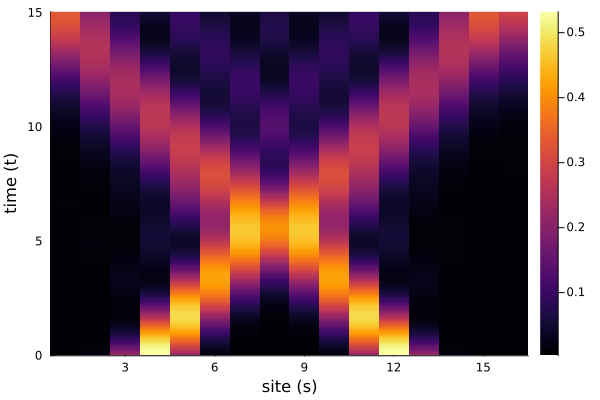

In [61]:
occs_mat = stack(occs, dims=1)

heatmap(1:N_s, 0:tau:(N_t*tau), occs_mat, xlabel="site (s)", ylabel="time (t)")

In [62]:
title = "Data/"
title *= "ising-exact-occs-N_s" * string(N_s)
title *= "-J" * string(J)
title *= "-h" * string(h)
title *= "-g" * string(g)
title *= "-width" * string(sigma)
title *= "-dt" * string(tau) * ".txt"
writedlm(title, occs_mat)

In [63]:
title

"Data/ising-exact-occs-N_s16-J0.2-h1-g0.3-width1.5-dt0.05.txt"

In [64]:
EEs_mat = stack(EEs, dims=1)
title = "Data/"
title *= "ising-exact-EEs-N_s" * string(N_s)
title *= "-J" * string(J)
title *= "-h" * string(h)
title *= "-g" * string(g)
title *= "-width" * string(sigma)
title *= "-dt" * string(tau) * ".txt"
writedlm(title, EEs_mat)

In [65]:
title

"Data/ising-exact-EEs-N_s16-J0.2-h1-g0.3-width1.5-dt0.05.txt"